In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import pandas as pd


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('datasets_combine.csv')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=False,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# LSTM Classifier Model
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        lstm_out, (hidden, _) = self.lstm(embedded)
        out = self.fc(hidden[-1])
        return out

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / len(val_loader.dataset)
    return avg_loss, accuracy

In [ ]:
# Model hyperparameters
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 2  # Adjust based on the number of target classes
num_epoch = 8

# Initialize T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')
VOCAB_SIZE = tokenizer.vocab_size

# Prepare the dataset and dataloader
train_texts, val_texts, train_labels, val_labels = train_test_split(df['sentence'], df['label'], test_size=0.2)
train_dataset = TextDataset(train_texts.tolist(), train_labels.tolist(), tokenizer, max_length=128)
val_dataset = TextDataset(val_texts.tolist(), val_labels.tolist(), tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, OUTPUT_DIM).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epoch):  # Number of epochs
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        predictions = model(input_ids)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    print(f'Epoch: {epoch + 1}, Loss: {total_loss / len(train_loader)}')
    print(f'Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')
# Save the model
torch.save(model.state_dict(), 'lstm_model.pth')

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch: 1, Loss: 0.6097256985740571
Val Loss: 0.17690640322939313, Val Accuracy: 0.947068145800317
Epoch: 2, Loss: 0.1425027880581874
Val Loss: 0.10817950676110658, Val Accuracy: 0.9622820919175912
Epoch: 3, Loss: 0.07167637172166871
Val Loss: 0.06415871713743215, Val Accuracy: 0.9822503961965134
Epoch: 4, Loss: 0.040490636312626775
Val Loss: 0.06144538441569441, Val Accuracy: 0.9819334389857369
Epoch: 5, Loss: 0.023878979516698966
Val Loss: 0.05169789118849851, Val Accuracy: 0.9841521394611727
Epoch: 6, Loss: 0.013796407848013023
Val Loss: 0.06933278487724807, Val Accuracy: 0.9828843106180666
Epoch: 7, Loss: 0.008215447434053249
Val Loss: 0.06982457951873051, Val Accuracy: 0.9828843106180666
Epoch: 8, Loss: 0.010055575172912
Val Loss: 0.0921620106209314, Val Accuracy: 0.9793977812995246


In [ ]:
def predict(text, model=model, tokenizer=tokenizer, device=device):
    model.eval()
    with torch.no_grad():
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=False,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].flatten().to(device)
        outputs = model(input_ids)

        # normalize the scores to all positive and sum to 1
        outputs = torch.nn.functional.softmax(outputs, dim=0)

        return outputs

In [ ]:
df = pd.read_csv('datasets_combine.csv')
df, test_df = train_test_split(df, test_size=0.1, random_state=42)


In [ ]:
def prepare_data(df):
    t5_data = []
    for index, row in df.iterrows():
        text = row['sentence']
        label = "Shakespearean" if row['label'] == 1 else "News"
        modified_text = f"{label} style: {text}"
        t5_data.append({'source': modified_text, 'target': modified_text})
    return t5_data


In [ ]:
t5_data = prepare_data(df)


In [ ]:
class T5StyleTransferDataset(Dataset):
    def __init__(self, tokenizer, data, max_length=512):
        self.tokenizer = tokenizer
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        source = item['source']
        target = item['target']

        # Tokenize source and target
        source_encoding = self.tokenizer(
            source,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        target_encoding = self.tokenizer(
            target,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        # Flatten the encoded tensors for compatibility with the model
        source_ids = source_encoding.input_ids.squeeze()
        target_ids = target_encoding.input_ids.squeeze()
        source_mask = source_encoding.attention_mask.squeeze()

        return {
            "input_ids": source_ids,
            "attention_mask": source_mask,
            "labels": target_ids
        }


In [ ]:
!pip install sentencepiece

In [ ]:
# Load T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model_TST = T5ForConditionalGeneration.from_pretrained('t5-small')


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# Prepare training and validation data
train_data, val_data = train_test_split(t5_data, test_size=0.1, random_state=42)
train_dataset = T5StyleTransferDataset(tokenizer, train_data)
val_dataset = T5StyleTransferDataset(tokenizer, val_data)


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model_TST,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()

Step,Training Loss
10,12.628800
20,12.871200
30,12.671200
40,13.008700
50,12.228600
60,10.866600
70,10.807800
80,11.054900
90,9.958000
100,8.636600


TrainOutput(global_step=9582, training_loss=0.17870260812132713, metrics={'train_runtime': 3591.8761, 'train_samples_per_second': 10.671, 'train_steps_per_second': 2.668, 'total_flos': 5187380566818816.0, 'train_loss': 0.17870260812132713, 'epoch': 3.0})

In [ ]:
!pip install transformers[torch]

In [ ]:
print(trainer.evaluate())

{'eval_loss': 9.424744348507375e-05, 'eval_runtime': 44.1595, 'eval_samples_per_second': 32.156, 'eval_steps_per_second': 8.039, 'epoch': 3.0}


In [ ]:
def transfer_style(sentence, model, tokenizer, device):
    model.eval()
    pre_classification = predict(sentence, model, tokenizer, device).tolist()
    style_label = 'Shakespearean style' if pre_classification[0] > pre_classification[1] else 'news style'
    # Prepare the input text with the desired style label
    input_text = f"{style_label}: {sentence}"
    # Prepare the input text with the desired style label
    # Encode the input text
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)

    # Generate the output
    with torch.no_grad():
        outputs = model_TST.generate(input_ids, max_length=512)
    print("generated sentence:",tokenizer.decode(outputs[0], skip_special_tokens=True))
    print("===========")
    # Decode and return the generated text
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
def wrapper_function(sentence):
    return style_transfer_t5(sentence, model, tokenizer)
df['generated_sentence'] = df['sentence'].apply(wrapper_function)


In [ ]:
def transfer_wraper(sentence):
    print(sentence)
    output = transfer_style(sentence, model, tokenizer, device)
    return output
test_df['transfer_result'] = test_df['sentence'].apply(transfer_wraper)

AUFIDIUS:I have not deserved it
generated sentence: AUFIDIUS:I have not deserved it
LARTIUS:So, let the ports be guarded: keep your duties,As I have set them down
generated sentence: LARTIUS:So, let the ports be guarded: keep your duties,As I have set them down
frustrated by heavy tax burdens and rising costs
generated sentence: frustrated by heavy tax burdens and rising costs
Tunisia weathered the Arab Spring and has been buoyed by its tourism industry
generated sentence: Tunisia weathered the Arab Spring and has been buoyed by its tourism industry
He says it will be a mix of classic hits and fan favorites
generated sentence: He says it will be a mix of classic hits and fan favorites
There might you have beheld onejoy crown another, so and in such manner that itseemed sorrow wept to take leave of them, for theirjoy waded in tears
generated sentence: There might you have beheld onejoy crown another, so and in such manner that itseemed sorrow wept to take leave of them, for theirjoy wad

In [ ]:
def label_generated_text_pred(sentence):
    label_prob = predict(sentence, model, tokenizer, device)
    if label_prob.tolist()[0] > 0.5:
        label = 0
    else:
        label = 1
    return label
test_df['label_generated_pred'] = test_df['transfer_result'].apply(label_generated_text_pred)

In [ ]:
def label_generated_text_real(original_label):
    if original_label == 0:
        label = 1
    else:
        label = 0
    return label
test_df['label_generated_real'] = test_df['label'].apply(label_generated_text_real)

In [ ]:
test_df

,sentence,label,transfer_result,label_generated_pred,label_generated_real
14345,AUFIDIUS:I have not deserved it,1,AUFIDIUS:I have not deserved it,1,0
11743,"LARTIUS:So, let the ports be guarded: keep you...",1,"LARTIUS:So, let the ports be guarded: keep you...",1,0
5733,frustrated by heavy tax burdens and rising costs,0,frustrated by heavy tax burdens and rising costs,0,1
5912,Tunisia weathered the Arab Spring and has been...,0,Tunisia weathered the Arab Spring and has been...,0,1
9574,He says it will be a mix of classic hits and f...,0,He says it will be a mix of classic hits and f...,0,1
...,...,...,...,...,...
5217,"Typhoon Phanfone hit central Japan on Monday, ...",0,"Typhoon Phanfone hit central Japan on Monday, ...",0,1
3522,Memphis Belle is the nickname given to crafts ...,0,Memphis Belle is the nickname given to crafts ...,0,1
14907,"First Huntsman:I will, my lord",1,"First Huntsman:I will, my lord",1,0
13431,"LOVEL:Come, come, dispatch; 'tis bootless to e...",1,"LOVEL:Come, come, dispatch; 'tis bootless to e...",1,0


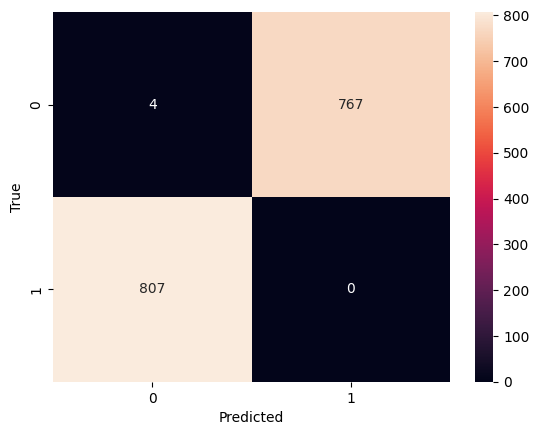

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_df['label_generated_real'], test_df['label_generated_pred'])
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

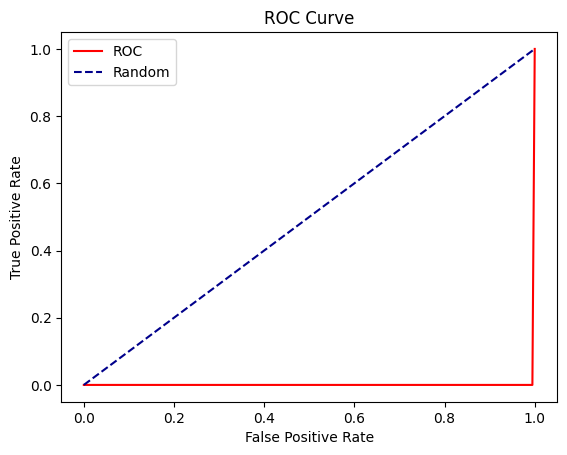

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
predict = test_df['label_generated_pred']
True_label = test_df['label_generated_real']
fpr, tpr, thresholds = roc_curve(True_label, predict)
auc = roc_auc_score(True_label, predict)
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
print(f'AUC: {auc}')

AUC: 0.0025940337224383825
